# Data Pipeline in PyTorch

In this tutorial, we shall build a flower identification model using [_Oxford 102 Flowers Dataset_](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) to learn data pipeline skill that will be useful handling complex scenarios where data is messier and challenging. A robust data pipeline can handle issues such as data accessbility and quality. In this tutorial you'll learn the techniques to make pipeline more reliable and model more robust. You'll add data augmentation to handle real world variations, run a single batch test to catch errors early, and add error handling so that one bad image doesn't crash the entire training run.

## Importing Packages

In [1]:
import os
import urllib.request as request    # For downloading data files
import tarfile                      # For extracting tar (.tgz) files
from scipy.io import loadmat        # For loading .mat files
from PIL import Image               # For image loading and processing
import random
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision.transforms.v2 as transform_v2                # For image transformations
from torch.utils.data import Dataset, DataLoader, random_split  # For creating custom datasets and loading data efficiently

## Data Ingestion

_Oxford 102 Flower Dataset_ consists of 102 flower categories. Each class consists of between 40 and 258 images. 
The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

After downloading and unzipping the dataset file, there will be a folder full of JPEG images generically named like image 0001.jpg. This is in constract to many datasets where images are neatly sorted into folders named after their categories, but that's not the case here. Instead, labels are stored separately in a .mat file, which is a compressed binary format from MATLAB. The labels needs to be extracted from this file.

**Downloading Data Files**

In [2]:
image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

# Creates dataset directory, if does not exist
dataset_folder = "./datasets/oxford_102_flowers"
os.makedirs(dataset_folder, exist_ok=True)

images_file_name = "102flowers.tgz"
images_file_path = os.path.join(dataset_folder, images_file_name)

labels_file_name = "imagelabels.mat"
labels_file_path = os.path.join(dataset_folder, labels_file_name)

# Downloads image file only if it does not exist
if not os.path.isfile(images_file_path):
    print(f"Images file {images_file_path} could not be found. Downloading...", end="")
    try:
        request.urlretrieve(image_url, os.path.join(dataset_folder, "102flowers.tgz"))
        print("successful.")
    except Exception as e:
        print(f"An error occurred while downloading: {e}")
else:
    print("Image file already exists. Downloading was skipped.")


# Downloads labels file only if it do not exist
if not os.path.isfile(labels_file_path):
    print(f"Labels file {labels_file_path} could not be found. Downloading...", end="")
    try:
        request.urlretrieve(labels_url, os.path.join(dataset_folder, "imagelabels.mat"))
        print("successful.")
    except Exception as e:
        print(f"An error occurred while downloading: {e}")
else:
    print("Labels file already exists. Downloading was skipped.")

Image file already exists. Downloading was skipped.
Labels file already exists. Downloading was skipped.


**Decompressing Data Files**

In [3]:
# Decompresses images file
if os.path.isfile(images_file_path):
    print(f"Decompressing {images_file_path}...", end="")
    try:
        with tarfile.open(images_file_path, "r:gz") as tar:
            tar.extractall(path=dataset_folder, filter='data')
        print("successful.")
    except Exception as e:
        print(f"An error occurred while decompressing: {e}")
    finally:
        tar.close()
else:
    print("Images file does not exist. Decompression was skipped.")

Decompressing ./datasets/oxford_102_flowers/102flowers.tgz...successful.


In [4]:
# Loads labels from .mat file
mat_contents = loadmat(labels_file_path)
labels = mat_contents["labels"][0]

In [5]:
print(f"Shape of Labels: {labels.shape}")  # Should be (8189,)

Shape of Labels: (8189,)


## Exploratory Data Analysis (EDA)

In [6]:
# Plots 15 random images in a figure to visualize them

random_labels = random.sample(range(0, len(labels)), 15)    # First, creates a list of 15 random numbers

# Then, creates a list of sample images based in the alredy generated random numbers
sample_images = [
    Image.open(
        os.path.join(dataset_folder, "jpg", f"image_{random_label :05d}.jpg")
    ) for random_label in random_labels
]

In [7]:
def plot_image_grid(nrows, ncols, images, labels, figsize=None, fig_title=None):
    """Plots a grid of images with their corresponding labels.

    Args:
        nrows (int): Number of rows in the grid.
        ncols (int): Number of columns in the grid.
        images (list): List of images to plot.
        labels (list): List of labels corresponding to the images.
        figsize (tuple, optional): Size of the figure. Defaults to None.
        fig_title (str, optional): Title of the figure. Defaults to "".
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()                               # Flattens the 2D array of axes to 1D for easier iteration
    for idx, image in enumerate(images):                # Iterates through the sample images to plot them
        axes[idx].imshow(image)                         # Displays the image in the corresponding subplot
        axes[idx].set_title(labels[idx])                # Sets the title of the subplot to the image label
        axes[idx].axis("off")                           # Hides the axis for a cleaner look

    if fig_title:
        plt.suptitle(fig_title, fontsize=16)            # Sets a main title for the entire figure
    plt.tight_layout()                                  # Adjusts layout to prevent overlap
    plt.show()

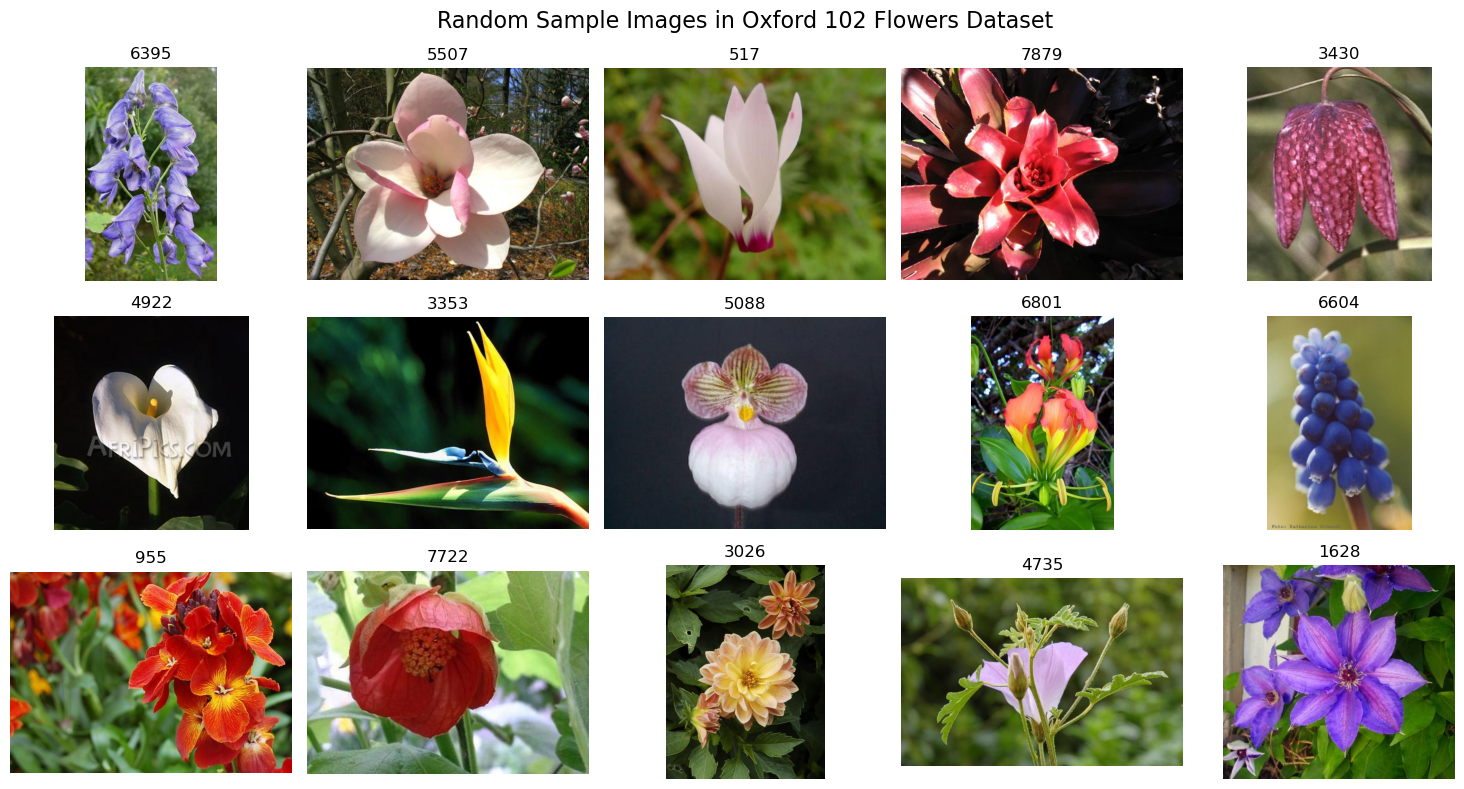

In [8]:
# Visualizes those samples images in a grid form
plot_image_grid(3, 5, sample_images, random_labels, figsize=(15, 8), fig_title="Random Sample Images in Oxford 102 Flowers Dataset")

In [9]:
# To confirm the image sizes varies as observed from the above plot,
# the sizes of those sample images get printed
[image.size for image in sample_images]

[(500, 815),
 (667, 500),
 (667, 500),
 (667, 500),
 (500, 580),
 (500, 548),
 (667, 500),
 (666, 500),
 (500, 751),
 (500, 740),
 (701, 500),
 (694, 500),
 (500, 675),
 (752, 500),
 (542, 500)]

In [10]:
# Checks one sample image for min. and max. pixel values for each channel
sample_images[0].getextrema()

((0, 255), (0, 255), (0, 255))

In [11]:
# Checks the minimum and maximum label values
print(f"Min. label value: {labels.min()}, Max. label value: {labels.max()}")

Min. label value: 1, Max. label value: 102


## Data Preparation

Handling image augmentation (only for training), resizing, format conversion, and normalization using PyTorch's transformation pipeline.

**Image Transformations**

In [112]:
# Composing image transformations comprising the following sequence of steps

transform = transform_v2.Compose([

    # Step 1: Resizes height and width of each image to 224
    transform_v2.Resize(256),           # First, resizes the shorter edge of the image 
    transform_v2.CenterCrop(224),       # Then crops the center square from the image

    # Step 2: Converts PIL images to tensor making 2-D image to 3-D adding channel information in the first dimension in the form of [<channels>, <height>, <width>]
    transform_v2.ToImage(),         

    # Step 3: Converts pixel value type from integer to float (required only if normalization expects float input)
    transform_v2.ToDtype(torch.float32, scale=True),
    
    # Step 4: Normalizes the pixel values against channel specific mean and std. provided in arguments.
    # These values for mean and standard deviations were found to be working very well in this particualr classification task.
    transform_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
])

In [178]:
# Composing image transformations exclusively for training comprising on-the-fly image 
# augmentations (not required for validation and test data transformation)

train_transform = transform_v2.Compose([

    # Step 1: On-the-fly image augmentation for model to recognize flowers in more varied situations.
    # (augmented version of the same image will be different in each epoch)
    transform_v2.RandomHorizontalFlip(),
    transform_v2.RandomRotation(degrees=10),
    transform_v2.ColorJitter(brightness=0.2),

    # Step 2: Resizes height and width of each image to 224
    transform_v2.Resize(256),           # First, resizes the shorter edge of the image 
    transform_v2.CenterCrop(224),       # Then crops the center square from the image

    # Step 3: Converts PIL images to tensor making 2-D image to 3-D adding channel information in the first dimension in the form of [<channels>, <height>, <width>]
    transform_v2.ToImage(),         

    # Step 4: Converts pixel value type from integer to float (required only if normalization expects float input)
    transform_v2.ToDtype(torch.float32, scale=True),
    
    # Step 5: Normalizes the pixel values against channel specific mean and std provided in arguments.
    # These values for mean and standard deviations were found to be working very well in this particualr classification task.
    transform_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     
])

**Checking the Tranformations**

In [115]:
# Applies the transformation to the sample images

transformed_sample_images = transform(sample_images)

# Checks if the shape (from 2-D to 3D) and sizes (from varying original to expected squared) were changed
[transformed_sample_image.shape for transformed_sample_image in transformed_sample_images]

[torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224])]

In [15]:
# Checks if the original pixels values from [0 to 255] range to standarized state with given channel specific mean and standard deviation
[f"Min: {transformed_sample_image.min()}, Max: {transformed_sample_image.max()}" for transformed_sample_image in transformed_sample_images]

['Min: -2.0665297508239746, Max: 2.640000104904175',
 'Min: -2.0665297508239746, Max: 2.640000104904175',
 'Min: -2.0357141494750977, Max: 2.239128828048706',
 'Min: -2.1179039478302, Max: 2.640000104904175',
 'Min: -1.7731091976165771, Max: 2.5877127647399902',
 'Min: -2.1007792949676514, Max: 2.640000104904175',
 'Min: -2.1179039478302, Max: 2.605142116546631',
 'Min: -1.8267831802368164, Max: 2.640000104904175',
 'Min: -2.1179039478302, Max: 2.640000104904175',
 'Min: -1.7030812501907349, Max: 2.552854299545288',
 'Min: -2.0357141494750977, Max: 2.248908281326294',
 'Min: -2.0357141494750977, Max: 2.640000104904175',
 'Min: -2.1179039478302, Max: 2.248908281326294',
 'Min: -1.8610327243804932, Max: 2.640000104904175',
 'Min: -2.1007792949676514, Max: 2.640000104904175']

**Checking the Train Tranformations**

In [16]:
train_transformed_sample_images = train_transform(sample_images)

# Checks if the shape (from 2-D to 3D) and sizes (from varying original to expected squared) were changed
[train_transformed_sample_image.shape for train_transformed_sample_image in train_transformed_sample_images]

[torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224]),
 torch.Size([3, 224, 224])]

In [17]:
# Checks if the original pixels values from [0 to 255] range to standarized state with given channel specific mean and standard deviation
[f"Min: {train_transformed_sample_image.min()}, Max: {train_transformed_sample_image.max()}" \
    for train_transformed_sample_image in train_transformed_sample_images]

['Min: -2.0836544036865234, Max: 2.047407865524292',
 'Min: -2.0836544036865234, Max: 2.0648369789123535',
 'Min: -2.0357141494750977, Max: 1.7162531614303589',
 'Min: -2.1179039478302, Max: 2.0648369789123535',
 'Min: -1.8256301879882812, Max: 2.0299785137176514',
 'Min: -2.1007792949676514, Max: 2.0648369789123535',
 'Min: -2.1179039478302, Max: 2.047407865524292',
 'Min: -1.878157377243042, Max: 2.0648369789123535',
 'Min: -2.1179039478302, Max: 2.0648369789123535',
 'Min: -1.7380951642990112, Max: 1.9428327083587646',
 'Min: -2.0357141494750977, Max: 1.6837916374206543',
 'Min: -2.0357141494750977, Max: 2.0648369789123535',
 'Min: -2.1179039478302, Max: 1.6837916374206543',
 'Min: -1.8952821493148804, Max: 2.0648369789123535',
 'Min: -2.1007792949676514, Max: 2.0648369789123535']

**Building Data Pipeline**

The primary steps to build the data pipeline to make model training efficient are

- Accessing the files and matching the images to their labels.
- Getting the images into the right format, correct size, data type, and structure for model to actually learn from them. 
- Finally, loading data in batches for efficient learning.

Primary tools to this task will be PyTorch's `Dataset` and `DataLoader` classes.

In [18]:
# Checks for labels
print(f"Labels Count: {len(labels)}, Min and max value for the labels: {labels.min()}, {labels.max()}")

Labels Count: 8189, Min and max value for the labels: 1, 102


In [ ]:
# Defines a custom `Dataset` class for Oxford 102 Flowers for PyTorch to handle the data, as required

class Oxford102FlowersDataset(Dataset):
    """Represents Oxford 102 Flowers Dataset that follows lazy loading pattern."""

    def __init__(self, root_dir, transform=None):
        """
        Initializes the Oxford 102 Flowers dataset.

        Args:
            root_dir (string): Path to the root directory containing images and labels.
            transform (callable, optional): Optional transformations to be applied on a sample.
        """

        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "jpg")
        self.transform = transform

        # Lists path for all images (for Dataset to load the images later on-the-fly)
        self.image_files = [f for f in os.listdir(self.images_dir) if f.endswith('.jpg')]

        # Loads labels from .mat file
        labels_file_path = os.path.join(self.root_dir, "imagelabels.mat")
        mat_contents = loadmat(labels_file_path)
        self.labels = mat_contents["labels"][0] - 1     # Adjusts labels to start from 0

        self.access_count = {}                          # Statistics on the individual images being accessed

        self.error_log = []                             # Keeps track of error during transformations

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_files)

    def __getitem__(self, idx):
        """Retrieves the image and label at the specified index."""
        try:
            # Prepares the image file name based on the index
            image_file_name = f'image_{idx + 1:05d}.jpg'    # Adds 1 to match with file name
            image_file_path = os.path.join(self.images_dir, image_file_name)

            # Loads the image
            image = Image.open(image_file_path)
            label = self.labels[idx]
            
            image.verify()                          # Checks the file for corruption (integrity check)
            image = Image.open(image_file_path)     # Reopens as `image.verify()` leaves the file in an unusable state

            # Skips smaller images (as it may break transformation)
            if image.size[0] < 32 or image.size[1] < 32:
                raise ValueError(f"Image is too small: {image.size}")
            
            # Converts gray-scale images to RGB
            if image.mode != "RGB":
                image = image.convert("RGB")

            # Applies transformations to the image
            if self.transform:
                image = self.transform(image)

            # Tracks how often each image is accessed [TELEMETRY]
            self.access_count[idx] = self.access_count.get(idx, 0) + 1

            return image, label
        except Exception as e:          # Handles problems such as corrupted file, etc. gracefully
            self.error_log.append({
                "index": idx,
                "error": str(e),
                "path": image_file_path if 'image_file_path' in locals() else 'unknown' 
            })
            print(f"WARNING: Skipping incompatible image {idx}: {e}")

            # Keeps pipeline moving even when files are broken 
            next_idx = (idx + 1) % len(self)
            return self.__getitem__(next_idx)   
    
    def get_error_summary(self):
        """Provides error summary to inspect which images had problems during loading or transformation."""
        
        if not self.error_log:
            print("No error occured during data loading.")
        else:
            print(f"Incompatibility found in {len(self.error_log)} images.")
            for error in self.error_log[:5]:
                print(f"  Index {error["index"]}: {error["error"]}")
            if len(self.error_log) > 5:
                print(f"  ... and {len(self.error_log) - 5} more.")

In [180]:
# Creates the Oxford 102 Flowers dataset
dataset = Oxford102FlowersDataset(root_dir=dataset_folder, transform=transform)

In [181]:
# Checks the dataset before further processing

print(f"Number of images files in the dataset: {len(dataset)}")

# Retrieves a sample image and label to verify functionality
sample_index = 0
sample_image, sample_label = dataset[sample_index]
print(f"\nSample Image:\n  Index: {sample_index}\n  Shape: {sample_image.shape}\n  Label: {sample_label}")

Number of images files in the dataset: 8189

Sample Image:
  Index: 0
  Shape: torch.Size([3, 224, 224])
  Label: 76


The below function can be used to check how augmented images look like and if there should be some ajustments required in the transformation steps.

In [ ]:
# def visualize_augmentations(dataset, image_idx):
#     """Visualizes multiple augmentations of a single image from the dataset.

#     Args:
#         dataset (Dataset): The dataset containing the images.
#         image_idx (int): The index of the image to visualize.
#     """
    
#     # Plots the original and augmented images
    
#     fig, axes = plt.subplots(2, 4, figsize=(15, 5))
    
#     for i in range(8):
#         image, label = dataset[image_idx]

#         image = denormalize_image(image)  # Denormalizes the image for proper visualization
#         axes[i].imshow(img.permute(1, 2, 0))  # Changes from [C, H, W] to [H, W, C] for plotting
#         ax.set_title(f"Augmented ver. {i + 1}")
#         ax.axis('off')
#     plt.suptitle("Augmented Versions of the Same Image", fontsize=16)
#     plt.tight_layout()
#     plt.show()

**Splitting Data**

Splitting the the full dataset into training, validation and test set.

The model gets trained on training set, validation set helps checking performance during training and to tune model paraneters while the test set is for final check on the trained model performance.

In [182]:
# Randomly splits the full dataset into train, validation and test set
# having ~5,700 (70%), ~1200 (15%) and ~1200 (15%) images, respectively.

train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15])

# Checks for the length of each of splitted dataset
print(f"Train set: {len(train_set)} images")
print(f"Validation set: {len(val_set)} images")
print(f"Test set: {len(test_set)} images")

Train set: 5733 images
Validation set: 1228 images
Test set: 1228 images


**Batching Data**

Setting up data loader for all sets of data (e.g. train set, validation set and test set) so that data loads in batches for efficiency.

In [ ]:
# Creating DataLoader for train set
train_set_loader = DataLoader(
    dataset=train_set, 
    batch_size=32,      # Number of images to be loaded in each batch
    shuffle=True        # Shuffling mixes all flower types in each batch for model to retain everything during its learning.
)

In [ ]:
# Creating DataLoader for validation set
val_set_loader = DataLoader(
    dataset=val_set, 
    batch_size=32,
    shuffle=False       # Shuffling is only required for training and not for model evaluation
)

In [174]:
# Creating DataLoader for test set
test_set_loader = DataLoader(
    dataset=test_set, 
    batch_size=32, 
    shuffle=False
)

In [175]:
# Performs a test run to ensure DataLoader is working as expected
for images, labels in train_set_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


The value **32** in the first shape of the batch indicates the number of images in that batch where each image contains **3** channels each with **[224 x 224]** pixels.

## Conclusion

In this notebook, you have learned how to create a robust and efficient data pipeline by implementing image transformations (such as resizing, changing data type, cropping, normalizing and optional augmentations), creating datasets and inserting telemetry in it, handling data pipeline errors, splitting dataset and testing pipeline. In the next module, we shall go through modeling and training aspect using data pipeline that we build in this notebook.
